In [2]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from duration_processor import (
    load_quiz_data,
    extract_format_time,
    sanitize_task_names,
    summarize_participant_by_format,
    plot_participant_time_by_format,
    summarize_tasks_by_format,
    plot_tasks_time_by_format,
    filter_tasks_by_list,
    participant_format_statistics,
    diagnose_all_json
)

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

In [ ]:
all_data

In [4]:
all_data['64457bc906c125cebd4bf66b'].keys()

dict_keys(['participantId', 'participantConfigHash', 'sequence', 'participantIndex', 'answers', 'searchParams', 'metadata', 'completed', 'rejected', 'participantTags'])

In [5]:
all_data['64457bc906c125cebd4bf66b']['answers'].keys()

dict_keys(['introduction', 'qualifications', 'consent', 'task', 'writing-task-NL', 'writing-task-NL_post-task-question', 'tutorial-json5-part1', 'tutorial-json5-part2', 'reading-task-tabular-json5-1', 'reading-task-tabular-json5-1_post-task-question', 'reading-task-tabular-json5-2', 'reading-task-tabular-json5-2_post-task-question', 'reading-task-tabular-json5-3', 'reading-task-tabular-json5-3_post-task-question', 'reading-task-tabular-json5-4', 'reading-task-tabular-json5-4_post-task-question', 'reading-task-tabular-json5-5', 'reading-task-tabular-json5-5_post-task-question', 'writing-task-tabular-json5', 'writing-task-tabular-json5_post-task-question', 'modifying-task-tabular-json5-1', 'modifying-task-tabular-json5-1_post-task-question', 'modifying-task-tabular-json5-2', 'modifying-task-tabular-json5-2_post-task-question', 'modifying-task-tabular-json5-3', 'modifying-task-tabular-json5-3_post-task-question', 'modifying-task-tabular-json5-4', 'modifying-task-tabular-json5-4_post-task-

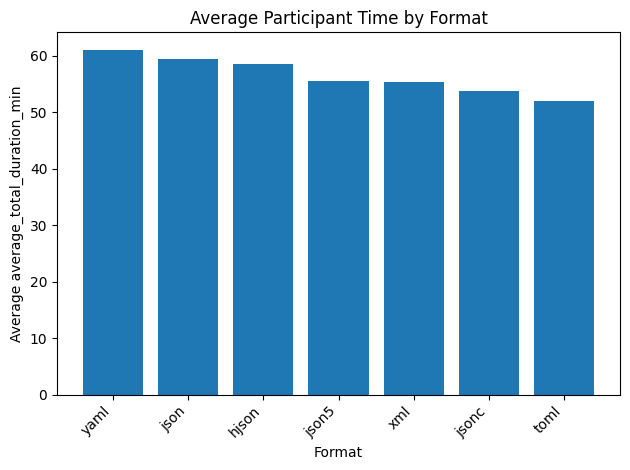

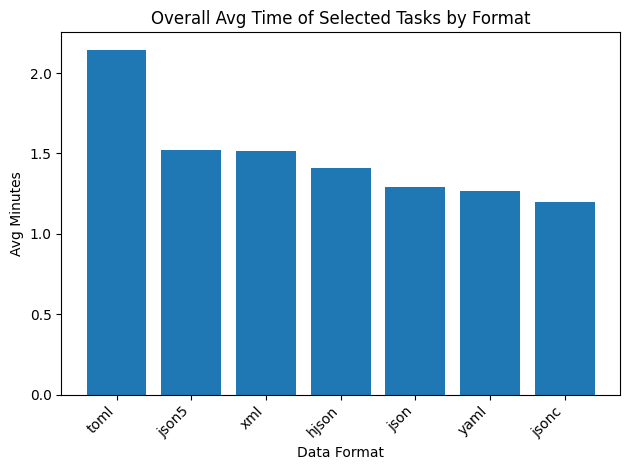

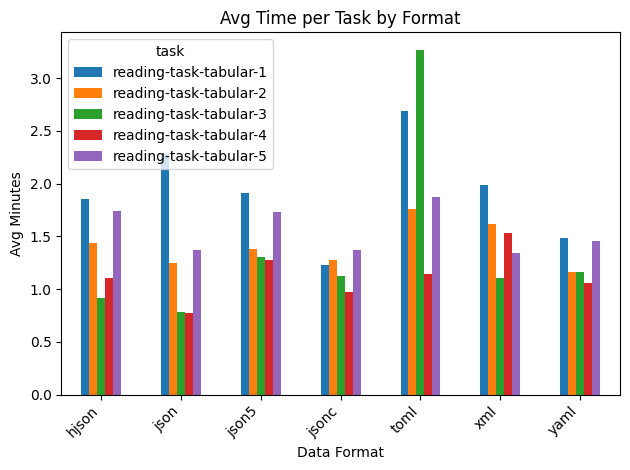

In [18]:
# extract format and duration
# df_participant: summarize participant's total time spent by format
df_task, df_participant = extract_format_time(all_data)

# clean 'format' from task name
df_task_clean = sanitize_task_names(df_task)
# diagnose_all_json(folder)

# average total time spent by format
df_part_summary = summarize_participant_by_format(df_participant)
fig1 = plot_participant_time_by_format(df_part_summary)

# 1. all tasks average time spent by format
task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3', 'reading-task-tabular-4', 'reading-task-tabular-5']
df_filtered = filter_tasks_by_list(df_task_clean, task_list)

df_overall = summarize_tasks_by_format(
    df_task_clean,
    metric='duration_min',
    task_list=task_list,
    mode='overall'
)
fig2 = plot_tasks_time_by_format(
    df_overall,
    metric='average_duration_min',
    mode='overall',
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# 2. each task average time spent by format
df_by_task = summarize_tasks_by_format(
    df_task_clean,
    task_list=task_list,
    metric='duration_min',
    mode='by_task'
)
fig3 = plot_tasks_time_by_format(
    df_by_task,
    metric='average_duration_min',
    mode='by_task',
    title='Avg Time per Task by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# df_task
# df_participant
# loaded, errors = diagnose_all_json(folder)

In [8]:
format_counts = participant_format_statistics(df_participant)
print(format_counts)

Total number of valid participants: 107
format
json     17
json5    15
hjson    15
yaml     15
toml     15
jsonc    15
xml      15
Name: count, dtype: int64


In [ ]:
all_data


Statsmodels ANOVA table:
                 sum_sq     df         F    PR(>F)
C(format)    989.626506    6.0  0.422865  0.862237
Residual   39004.790567  100.0       NaN       NaN

result interpretation: 
Levene's test for homogeneity of variances: W = 0.488, p = 0.816 (> 0.05). Variances are not significantly different.
One-way ANOVA: F = 0.423, p = 0.862.
→ p ≥ 0.05: Cannot reject the null hypothesis; no significant difference in means between groups.



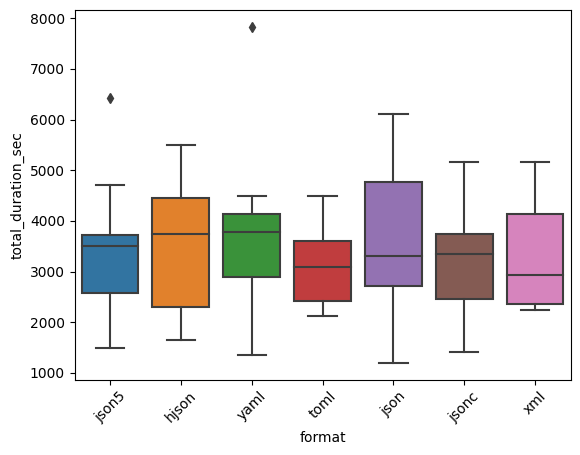


Outliers detected:


,participantId,format,total_duration_sec,total_duration_min,outlier_group,lower_bound,upper_bound
0,67d163e7b7bcc1e9718e01da,json5,6416.125,106.94,json5,842.62025,5454.10225
1,671a519900a99ebc15a67672,yaml,7830.358,130.51,yaml,1023.66275,5991.35275


In [9]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

def test_duration_by_format(
    df: pd.DataFrame,
    duration_col: str = 'total_duration_min',
    factor_col: str = 'format'
) -> dict:
    """
    Perform Levene's test for homogeneity of variances, followed by either
    one-way ANOVA or Kruskal–Wallis test on `duration_col` grouped by `factor_col`.
    Returns a dictionary containing:
      - 'levene': (statistic, p-value)
      - 'method': 'ANOVA' or 'Kruskal–Wallis'
      - 'stat': F-statistic or H-statistic
      - 'p_value': p-value of the chosen test
      - 'tukey': TukeyHSDResults object if ANOVA was used, else None
      - 'anova_table': pandas DataFrame with Type II ANOVA table from statsmodels
    """
    # Prepare a list of arrays, one per group
    grouped = df.groupby(factor_col)
    groups = [group[duration_col].values for _, group in grouped]
    if len(groups) < 2:
        raise ValueError("At least two groups are required for the comparison.")

    # 1) Levene's test for homogeneity of variances
    w_stat, p_levene = levene(*groups)

    # 2) Choose between ANOVA and Kruskal–Wallis based on Levene's result
    if p_levene > 0.05:
        stat, pval = f_oneway(*groups)
        method = 'ANOVA'
    else:
        stat, pval = kruskal(*groups)
        method = 'Kruskal–Wallis'

    # 3) If ANOVA was used, perform Tukey HSD post-hoc comparisons
    tukey = None
    if method == 'ANOVA':
        tukey = pairwise_tukeyhsd(
            endog=df[duration_col],
            groups=df[factor_col],
            alpha=0.05
        )

    # 4) Generate a Type II ANOVA table with statsmodels
    model = ols(f'{duration_col} ~ C({factor_col})', data=df).fit()
    anova_table = anova_lm(model, typ=2)

    return {
        'levene': (w_stat, p_levene),
        'method': method,
        'stat': stat,
        'p_value': pval,
        'tukey': tukey,
        'anova_table': anova_table
    }

def interpret_duration_results(results: dict) -> str:
    """
    Generate an English interpretation of the statistical test results
    dictionary returned by `test_duration_by_format`.
    """
    w_stat, p_levene = results['levene']
    method = results['method']
    stat = results['stat']
    pval = results['p_value']

    lines = []
    # Interpret Levene's test
    if p_levene > 0.05:
        lines.append(
            f"Levene's test for homogeneity of variances: W = {w_stat:.3f}, "
            f"p = {p_levene:.3f} (> 0.05). Variances are not significantly different.\n"
        )
    else:
        lines.append(
            f"Levene's test for homogeneity of variances: W = {w_stat:.3f}, "
            f"p = {p_levene:.3f} (≤ 0.05). Variances differ significantly; "
            f"using {method}.\n"
        )

    # Interpret main test
    if method == 'ANOVA':
        lines.append(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}.\n")
        if pval < 0.05:
            lines.append(
                "→ p < 0.05: Reject the null hypothesis of equal means; "
                "there is a significant difference between groups.\n"
            )
            lines.append(
                "  Check the Tukey HSD results to see which pairs differ.\n"
            )
        else:
            lines.append(
                "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                "no significant difference in means between groups.\n"
            )
    else:
        lines.append(f"Kruskal–Wallis H = {stat:.3f}, p = {pval:.3f}.\n")
        if pval < 0.05:
            lines.append(
                "→ p < 0.05: Reject the null hypothesis; "
                "there is a significant difference between groups.\n"
            )
        else:
            lines.append(
                "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                "no significant difference between groups.\n"
            )

    return "".join(lines)

def extract_outliers(
    df: pd.DataFrame,
    group_col: str,
    value_col: str
) -> pd.DataFrame:
    """
    Identify outliers in `value_col` within each group defined by `group_col`
    using the 1.5 × IQR rule. Returns a DataFrame containing only the outlier rows,
    with additional columns:
      - outlier_group: the group name
      - lower_bound: lower threshold used
      - upper_bound: upper threshold used
    """
    outliers_list = []

    for group_name, group_df in df.groupby(group_col):
        q1 = group_df[value_col].quantile(0.25)
        q3 = group_df[value_col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        mask = (group_df[value_col] < lower_bound) | (group_df[value_col] > upper_bound)
        outlier_rows = group_df.loc[mask].copy()
        if not outlier_rows.empty:
            outlier_rows['outlier_group'] = group_name
            outlier_rows['lower_bound'] = lower_bound
            outlier_rows['upper_bound'] = upper_bound
            outliers_list.append(outlier_rows)

    if outliers_list:
        return pd.concat(outliers_list, ignore_index=True)
    else:
        # Return an empty DataFrame with the same structure
        cols = list(df.columns) + ['outlier_group', 'lower_bound', 'upper_bound']
        return pd.DataFrame(columns=cols)

# ========== Example Usage ==========

# Assume df_participant is already loaded and contains:
# ['participantId', 'format', 'total_duration_min']

# Run the statistical tests
results = test_duration_by_format(
    df_participant,
    duration_col='total_duration_min',
    factor_col='format'
)

print("\nStatsmodels ANOVA table:")
print(results['anova_table'])

print("\nresult interpretation: ")
print(interpret_duration_results(results))

outliers = extract_outliers(df_participant, 'format', 'total_duration_sec')


sns.boxplot(x='format', y='total_duration_sec', data=df_participant)
plt.xticks(rotation=45)
plt.show()

print("\nOutliers detected:")
outliers

In [19]:
import pandas as pd
import re
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def process_task_data(df_task: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and aggregate task-level duration data.

    Steps:
      1. Keep only relevant columns.
      2. Remove tasks ending with '_post-task-question' and 'unqualified'.
      3. Preserve original task rows (task_group = task).
      4. Aggregate all 'modifying-', 'reading-', and 'writing-task-tabular-' subtasks
         into their parent task_group by summing duration_min.
      5. Aggregate all 'tutorial-<format>-partX' subtasks into 'tutorial-<format>' 
         by summing duration_min.
    Returns a DataFrame with columns:
      ['participantId', 'task_group', 'format', 'duration_min']
    """
    # Select and filter relevant rows
    df = df_task[['participantId', 'task', 'duration_min', 'format']].copy()
    df = df[~df['task'].str.endswith('_post-task-question')]
    df = df[df['task'] != 'unqualified']
    
    # 1) Preserve original rows: task_group = original task name
    df_orig = df.rename(columns={'task': 'task_group'})[
        ['participantId', 'task_group', 'format', 'duration_min']
    ]
    
    agg_frames = []
    # 2) Aggregate tabular subtasks into top-level task_group
    for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
        mask = df['task'].str.startswith(prefix + '-')
        if mask.any():
            tmp = (
                df[mask]
                .groupby(['participantId', 'format'], as_index=False)['duration_min']
                .sum()
            )
            tmp['task_group'] = prefix
            agg_frames.append(tmp[['participantId', 'task_group', 'format', 'duration_min']])
    
    # 3) Aggregate tutorial subtasks into 'tutorial-<format>'
    tutorial_mask = df['task'].str.match(r'^tutorial-[^-]+-part\d+$')
    if tutorial_mask.any():
        df_tut = df[tutorial_mask].copy()
        df_tut['task_group'] = df_tut['task'].str.replace(r'-part\d+$', '', regex=True)
        tmp2 = (
            df_tut
            .groupby(['participantId', 'format', 'task_group'], as_index=False)['duration_min']
            .sum()
        )
        agg_frames.append(tmp2[['participantId', 'task_group', 'format', 'duration_min']])
    
    # Combine original and aggregated rows
    df_combined = pd.concat([df_orig] + agg_frames, ignore_index=True)
    return df_combined


def test_format_duration(df_combined: pd.DataFrame, task_list: list):
    """
    For each task in task_list (raw or aggregated name):
      1. Canonicalize the task name (e.g., 'modifying-task-tabular-1' → 'modifying-task-tabular').
      2. Ensure there are at least two formats; skip otherwise.
      3. Perform Levene's test for variance homogeneity.
      4. If variances are homogeneous, run one-way ANOVA; else run Kruskal–Wallis.
      5. If ANOVA was used, perform Tukey HSD post-hoc comparisons.
      6. Print results and return a dictionary of statistics.
    """
    results = {}
    for raw_task in task_list:
        # Map raw_task to its canonical aggregated name
        canonical = raw_task
        for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
            if raw_task.startswith(prefix + '-'):
                canonical = prefix
                break
        else:
            if re.match(r'^tutorial-[^-]+-part\d+$', raw_task):
                canonical = re.sub(r'-part\d+$', '', raw_task)
        
        sub = df_combined[df_combined['task_group'] == canonical]
        if sub.empty:
            print(f"⚠️ No data found for task '{raw_task}' (canonical '{canonical}'), skipping.")
            continue
        
        formats = sub['format'].unique()
        if len(formats) < 2:
            print(f"⚠️ Task '{raw_task}' (canonical '{canonical}') has only one format: {formats.tolist()}, skipping.")
            continue
        
        # Prepare groups of duration values
        groups = [group['duration_min'].values for _, group in sub.groupby('format')]
        
        # 1) Levene's test
        w_stat, p_levene = levene(*groups)
        
        # 2) Choose test based on variance homogeneity
        if p_levene > 0.05:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            stat, pval = kruskal(*groups)
            method = 'Kruskal–Wallis'
        
        # 3) Tukey HSD if ANOVA
        tukey = None
        if method == 'ANOVA':
            tukey = pairwise_tukeyhsd(
                endog=sub['duration_min'],
                groups=sub['format'],
                alpha=0.05
            )
        
        # Print results
        print(f"\n=== Task: {raw_task} → Aggregated as: {canonical} ===")
        print(f"Levene's test: W = {w_stat:.3f}, p = {p_levene:.3f}")
        if method == 'ANOVA':
            print(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}")
            print(tukey)
        else:
            print(f"Kruskal–Wallis: H = {stat:.3f}, p = {pval:.3f}")
        print('-' * 40)
        
        results[raw_task] = {
            'canonical': canonical,
            'method': method,
            'stat': stat,
            'p_value': pval,
            'levene': (w_stat, p_levene),
            'tukey': tukey
        }
    return results


def generate_interpretation(results: dict) -> dict:
    """
    Given the output of test_format_duration, automatically generate
    an English interpretation for each task.
    Returns a dict mapping raw_task to its interpretation string.
    """
    interpretations = {}
    for raw_task, info in results.items():
        canonical = info['canonical']
        w_stat, p_levene = info['levene']
        method = info['method']
        stat = info['stat']
        pval = info['p_value']
        
        lines = [f"=== Task: '{raw_task}' (aggregated as '{canonical}') ===\n"]
        
        # Interpret Levene's test
        if p_levene > 0.05:
            lines.append(
                f"Levene's test p = {p_levene:.3f} (> 0.05): "
                "variances are homogeneous across formats.\n"
            )
        else:
            lines.append(
                f"Levene's test p = {p_levene:.3f} (≤ 0.05): "
                "variances are not homogeneous; proceeding with "
                f"{method}.\n"
            )
        
        # Interpret main test
        if method == 'ANOVA':
            lines.append(f"One-way ANOVA result: F = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < 0.05:
                lines.append(
                    "→ p < 0.05: Reject the null hypothesis of equal means; "
                    "significant differences exist between formats.\n"
                )
                lines.append(
                    "  Check Tukey HSD post-hoc comparisons to identify which pairs differ.\n"
                )
            else:
                lines.append(
                    "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                    "no significant differences in mean duration across formats.\n"
                )
        else:
            lines.append(f"Kruskal–Wallis result: H = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < 0.05:
                lines.append(
                    "→ p < 0.05: Reject the null hypothesis; "
                    "significant differences exist between formats.\n"
                )
            else:
                lines.append(
                    "→ p ≥ 0.05: Cannot reject the null hypothesis; "
                    "no significant differences between formats.\n"
                )
        
        interpretations[raw_task] = "".join(lines)
    return interpretations

def summarize_significance(results: dict, alpha: float = 0.05) -> pd.DataFrame:
    """
    根据 test_format_duration 的输出 results，返回一个 DataFrame，总结每个任务是否存在显著性差异。
    列包括：
      - task: 原始任务名
      - aggregated: 聚合后的 canonical 名
      - method: 使用的检验方法（ANOVA 或 Kruskal–Wallis）
      - p_value: 主检验的 p 值
      - significant: True 表示 p < alpha，存在显著差异；False 则无显著差异
    """
    rows = []
    for raw_task, info in results.items():
        pval = info['p_value']
        rows.append({
            'task': raw_task,
            'aggregated': info['canonical'],
            'method': info['method'],
            'p_value': pval,
            'significant': pval < alpha
        })
    return pd.DataFrame(rows)

def get_significance_lists(results: dict, alpha: float = 0.05) -> dict:
    """
    返回两个列表：
      - 'significant': 存在显著差异的任务列表
      - 'not_significant': 无显著差异的任务列表
    """
    sig = [t for t, info in results.items() if info['p_value'] < alpha]
    nonsig = [t for t, info in results.items() if info['p_value'] >= alpha]
    return {
        'significant': sig,
        'not_significant': nonsig
    }


In [20]:
df_proc = process_task_data(df_task)
df_proc['task_group'].unique()

array(['introduction', 'qualifications', 'consent', 'task',
       'writing-task-NL', 'tutorial-json5-part1', 'tutorial-json5-part2',
       'reading-task-tabular-json5-1', 'reading-task-tabular-json5-2',
       'reading-task-tabular-json5-3', 'reading-task-tabular-json5-4',
       'reading-task-tabular-json5-5', 'writing-task-tabular-json5',
       'modifying-task-tabular-json5-1', 'modifying-task-tabular-json5-2',
       'modifying-task-tabular-json5-3', 'modifying-task-tabular-json5-4',
       '$nasa-tlx.co.nasa-tlx', 'post-task-survey-tlx',
       'tutorial-hjson-part1', 'tutorial-hjson-part2',
       'reading-task-tabular-hjson-1', 'reading-task-tabular-hjson-2',
       'reading-task-tabular-hjson-3', 'reading-task-tabular-hjson-4',
       'reading-task-tabular-hjson-5', 'writing-task-tabular-hjson',
       'modifying-task-tabular-hjson-1', 'modifying-task-tabular-hjson-2',
       'modifying-task-tabular-hjson-3', 'modifying-task-tabular-hjson-4',
       'tutorial-yaml-part1', 'tu

In [21]:
tasks = [
    'modifying-task-tabular',
    'modifying-task-tabular-1',
    'modifying-task-tabular-2',
    'modifying-task-tabular-3',
    'modifying-task-tabular-4',
    'reading-task-tabular',
    'reading-task-tabular-1',
    'reading-task-tabular-2',
    'reading-task-tabular-3',
    'reading-task-tabular-4',
    'reading-task-tabular-5',
    'writing-task-tabular',
    'writing-task-NL'
]
res = test_format_duration(df_proc, tasks)
interpretations = generate_interpretation(res)
for raw, txt in interpretations.items():
    print(txt)


# 2. 生成摘要表
summary_df = summarize_significance(res)
# print(summary_df)

# 或者直接拿列表：
lists = get_significance_lists(res)
print("significant：", lists['significant'])
print("not significant：", lists['not_significant'])


=== Task: modifying-task-tabular → Aggregated as: modifying-task-tabular ===
Levene's test: W = 0.461, p = 0.836
One-way ANOVA: F = 1.514, p = 0.181
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 hjson   json    0.495    1.0  -7.7701  8.7601  False
 hjson  json5  -1.4581 0.9986  -9.9776  7.0614  False
 hjson  jsonc  -2.7633  0.958 -11.2828  5.7562  False
 hjson   toml  -2.4252  0.978 -10.9447  6.0942  False
 hjson    xml   0.7321    1.0  -7.7874  9.2515  False
 hjson   yaml   4.4793 0.6939  -4.0402 12.9988  False
  json  json5  -1.9531 0.9916 -10.2182   6.312  False
  json  jsonc  -3.2583 0.8978 -11.5234  5.0069  False
  json   toml  -2.9202 0.9372 -11.1854  5.3449  False
  json    xml    0.237    1.0  -8.0281  8.5022  False
  json   yaml   3.9843 0.7728  -4.2808 12.2494  False
 json5  jsonc  -1.3052 0.9992  -9.8247  7.2143  False
 json5   toml  -0.9672 0.9999  -9.4867  

In [22]:
lists

{'significant': [],
 'not_significant': ['modifying-task-tabular',
  'modifying-task-tabular-1',
  'modifying-task-tabular-2',
  'modifying-task-tabular-3',
  'modifying-task-tabular-4',
  'reading-task-tabular',
  'reading-task-tabular-1',
  'reading-task-tabular-2',
  'reading-task-tabular-3',
  'reading-task-tabular-4',
  'reading-task-tabular-5',
  'writing-task-tabular',
  'writing-task-NL']}

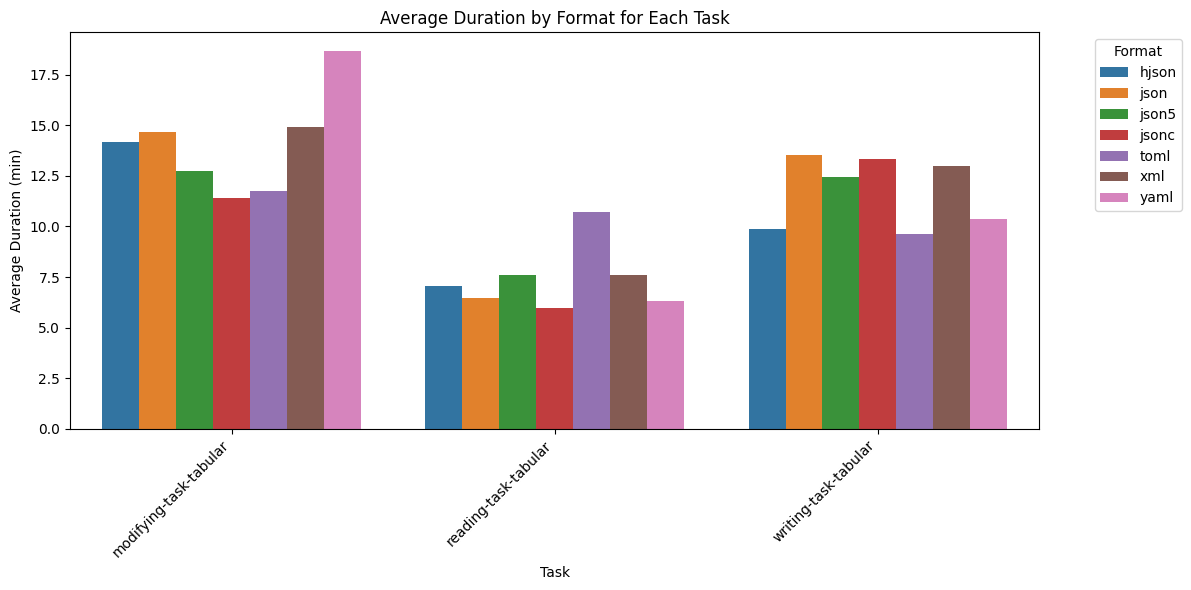

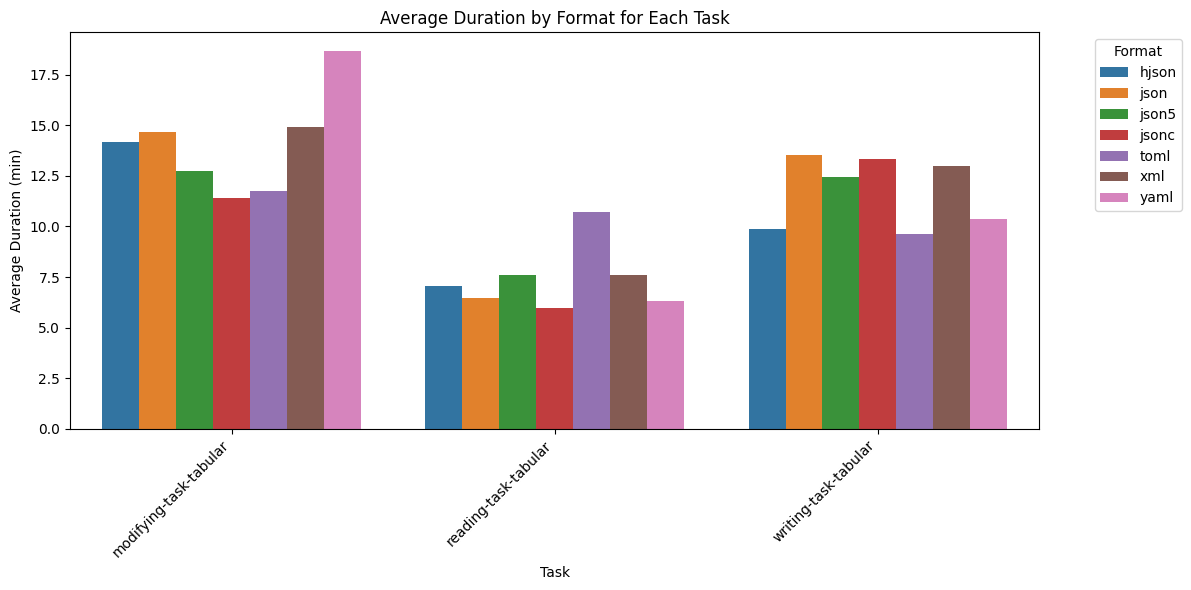

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_proc and tasks are already defined in the environment:
# df_proc: DataFrame from process_task_data(df_task)
# tasks: list of task_group names to visualize

def plot_avg_duration_by_task(df, tasks, task_col='task_group', format_col='format', duration_col='duration_min'):
    """
    Plots the average duration per format for each specified task.

    Parameters:
    - df: DataFrame containing columns [task_group, format, duration_min]
    - tasks: list of task_group names to include in the plot
    - task_col: name of the task grouping column
    - format_col: name of the format grouping column
    - duration_col: name of the duration column
    """
    # Filter to selected tasks
    df_filtered = df[df[task_col].isin(tasks)]
    
    # Compute average duration per task and format
    avg_df = (
        df_filtered
        .groupby([task_col, format_col])[duration_col]
        .mean()
        .reset_index()
    )
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=avg_df,
        x=task_col,
        y=duration_col,
        hue=format_col,
        ci=None
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Duration (min)')
    plt.xlabel('Task')
    plt.title('Average Duration by Format for Each Task')
    plt.legend(title='Format', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example call:
plot_avg_duration_by_task(df_proc, tasks)

df_proc = process_task_data(df_task)

# 2. 定义 tasks 列表
tasks = [
    'modifying-task-tabular',
    # 'modifying-task-tabular-1',
    # 'modifying-task-tabular-2',
    # 'modifying-task-tabular-3',
    # 'modifying-task-tabular-4',
    'reading-task-tabular',
    # 'reading-task-tabular-1',
    # 'reading-task-tabular-2',
    # 'reading-task-tabular-3',
    # 'reading-task-tabular-4',
    # 'reading-task-tabular-5',
    'writing-task-tabular'
    # 'writing-task-NL'
]

# 3. 调用可视化函数
plot_avg_duration_by_task(df_proc, tasks)